# Assignment

Use the "from the expert" (FTE) jupyter notebook as a starter for this assignment, and ask your instructor questions if you need help.

Use the `churn_data.csv` file to carry out a similar data cleaning and preparation as we did in the FTE. Specifically, at least complete these minimum requirements:

- Check for outliers in numeric data, and deal with them if needed
- Check for missing values, and decide how to deal with them if needed
- Convert categorical columns to numeric values
- Create at least one new feature by combining multiple columns. For example, you could calculate the ratio of total charges to tenure. Create at least one plot for your new feature.
- Save the data to a csv (or another filetype of your choice) for use next week.
- Write a short analysis at the end of the notebook describing your findings and what you did.

You can do more data cleaning, preparation, and EDA beyond these basic requirements if you want to learn more and develop your data science skills. For example, you could use a box-cox transformation on the numeric data or try other outlier methods.

### DS process status

Here is our data science process, and where we are (#3):

**1. Business understanding**

Can we use machine learning to predict if a customer will churn before they leave?

**2. Data understanding**

Done in week 1 (mostly), this is iterative so you might do more of this as we go on.

**3. Data preparation**

We are here this week.


**4. Modeling**

Next week


**5. Evaluation**

Next week


**6. Deployment**

Next week

## Load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('data/churn_data.csv', index_col='customerID')
df

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...
6840-RESVB,24,Yes,One year,Mailed check,84.80,1990.50,No
2234-XADUH,72,Yes,One year,Credit card (automatic),103.20,7362.90,No
4801-JZAZL,11,No,Month-to-month,Electronic check,29.60,346.45,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   PhoneService    7043 non-null   object 
 2   Contract        7043 non-null   object 
 3   PaymentMethod   7043 non-null   object 
 4   MonthlyCharges  7043 non-null   float64
 5   TotalCharges    7032 non-null   float64
 6   Churn           7043 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 440.2+ KB


## Check for outliers

<AxesSubplot:>

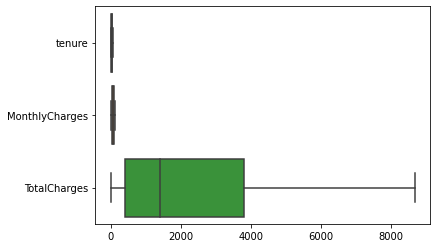

In [4]:
sns.boxplot(data=df, orient='h')

In [5]:
# loop through numeric columns and check for outliers
for column in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_boundary = q3 + 1.5 * iqr
    lower_boundary = q1 - 1.5 * iqr
    outliers = df[(df[column] < lower_boundary) | (df[column] > upper_boundary)][column]
    if outliers.shape[0] > 0:
        print(outliers)
    else:
        # this is called f-string formatting
        print(f'no outliers for {column}')

no outliers for tenure
no outliers for MonthlyCharges
no outliers for TotalCharges


### Missing values

In [6]:
df.isna().sum()

tenure             0
PhoneService       0
Contract           0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

In [7]:
# fill missing values with median, since distribution is skewed
df.fillna(df['TotalCharges'].median(), inplace=True)

### Convert categorical data to numeric

Using map here requires that we have a value to replace for each existing value in the dataframe.

In [8]:
yn_dict = {'Yes': 1, 'No': 0}

In [9]:
df['PhoneService'] = df['PhoneService'].replace(yn_dict)

In [10]:
df['PaymentMethod'] = df['PaymentMethod'].replace({'Electronic check': 3,
                                               'Mailed check': 2,
                                               'Bank transfer (automatic)': 1,
                                               'Credit card (automatic)': 0})

In [11]:
df['Contract'] = df['Contract'].replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

In [12]:
df['Churn'] = df['Churn'].replace(yn_dict)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   PhoneService    7043 non-null   int64  
 2   Contract        7043 non-null   int64  
 3   PaymentMethod   7043 non-null   int64  
 4   MonthlyCharges  7043 non-null   float64
 5   TotalCharges    7043 non-null   float64
 6   Churn           7043 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 440.2+ KB


### Feature engineering

Once you try and plot a histogram of the charge per tenure, you realize the values where tenure is 0 result in a division by 0, which is infinity. We can add 1 to the tenure in the calculation to avoid this like `df['charge_per_tenure'] = df['TotalCharges'] / (df['tenure'] + 1)`. It seems strange that the same total charges are there for tenure = 0. It looks like these are examples where tenure should actually be a missing value. We will set these values to NaN then fill them with the median value. 

In [14]:
df[df['tenure'] == 0]

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
4472-LVYGI,0,0,2,1,52.55,1397.475,0
3115-CZMZD,0,1,2,2,20.25,1397.475,0
5709-LVOEQ,0,1,2,2,80.85,1397.475,0
4367-NUYAO,0,1,2,2,25.75,1397.475,0
1371-DWPAZ,0,0,2,0,56.05,1397.475,0
7644-OMVMY,0,1,2,2,19.85,1397.475,0
3213-VVOLG,0,1,2,2,25.35,1397.475,0
2520-SGTTA,0,1,2,2,20.00,1397.475,0
2923-ARZLG,0,1,1,2,19.70,1397.475,0


In [15]:
df.at[df['tenure'] == 0, 'tenure'] = np.nan
df['tenure'].fillna(df['tenure'].median(), inplace=True)

In [16]:
df['charge_per_tenure'] = df['TotalCharges'] / (df['tenure'])

<AxesSubplot:xlabel='charge_per_tenure', ylabel='Count'>

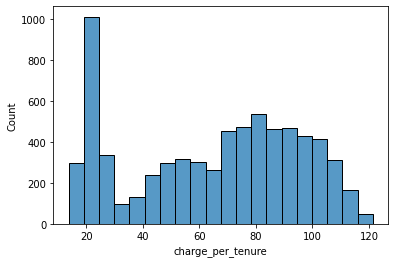

In [17]:
sns.histplot(data=df, x='charge_per_tenure')

In [18]:
df.head()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,charge_per_tenure
customerID,,,,,,,,
7590-VHVEG,1.0,0,0,3,29.85,29.85,0,29.850000
5575-GNVDE,34.0,1,1,2,56.95,1889.50,0,55.573529
3668-QPYBK,2.0,1,0,2,53.85,108.15,1,54.075000
7795-CFOCW,45.0,0,1,1,42.30,1840.75,0,40.905556
9237-HQITU,2.0,1,0,3,70.70,151.65,1,75.825000


In [19]:
df.to_csv('prepared_churn_data.csv')

### Summary

We cleaned and feature engineered the churn dataset. We evaluated the dataset for outliers first using the IQR method and found no outliers present in the dataset. From looking at the numeric data histograms, we don't expect to see any outliers. We found some missing values in the total charges column, and filled them with the median since the distribution is skewed. We could probably fill them with better values if we looked at the data more - potentially we could use the tenure and monthly charge column to predict the total charge column using ML imputation. Next, we converted the categorical columns to numeric datatypes with label encoding - a unique number for each value. Finally, we created one new feature which is the charge per tenure, by dividing total charges by the tenure. In the process, we found there were some tenure values of 0, which appear to be actually missing values. We set these to NaN then filled them with the median value before creating the new feature. We now have the data saved in a CSV file and ready for next steps.